In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm

from Helper.ImportDatasetsFairness import df_epsilon, df_epsilon_crit, networks
from Method.QuantileUncertaintyCalculations import *

log_crit_epsilons_network = {}

for network in networks:
    # Take all critical epsilons of the test set and put into numpy array
    df_for_network = df_epsilon_crit[df_epsilon_crit['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_for_network = df_for_network.dropna() # Drop NaN values
    log_crit_epsilons_network[network] = np.log(df_for_network['Epsilon'].to_numpy())

# Steps to finish experiments
<del>1. Implement the frequentist methods that assume log normal distribution. Put this into a Method python file. </del>

<del>2. See how each method (Non parametric, parametric 1, parametric 2) acts on n choose N data points and increase n, nonformally </del>

3. Conclude something about how well each method performs at estimating the quantile (with a graph), a.k.a formalize it

And then you can start writing and asking for feedback!

In [4]:
dat = log_crit_epsilons_network[networks[0]]
mean = np.mean(dat)
std = np.std(dat)

nonparam = get_quantile(dat, 0.05)
param1 = get_quantile_normal_orderdistr(dat, 0.05, mean, std)
param2 = get_quantile_normal_tdistr(dat, 0.05, mean, std)

(-4.8, -4.3)

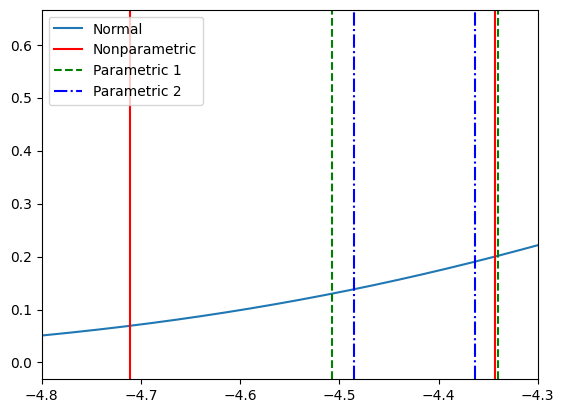

In [5]:
# plot normal with mean and std
x = np.linspace(np.min(dat), np.max(dat), 10000)
plt.plot(x, norm.pdf(x, mean, std), label='Normal')

plt.axvline(nonparam[1], color='r', label='Nonparametric')
plt.axvline(nonparam[2], color='r')

plt.axvline(param1[1], color='g', label='Parametric 1', linestyle='--')
plt.axvline(param1[2], color='g', linestyle='--')

plt.axvline(param2[0], color='b', label='Parametric 2', linestyle='-.')
plt.axvline(param2[1], color='b', linestyle='-.')

plt.legend()
plt.xlim(-4.8,-4.3)

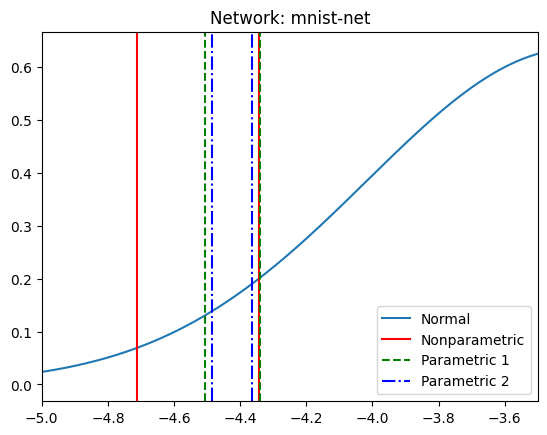

Network: mnist-net
Is Parametric 1 inside Nonparametric: False
Is Parametric 2 inside Nonparametric: True
------------------------


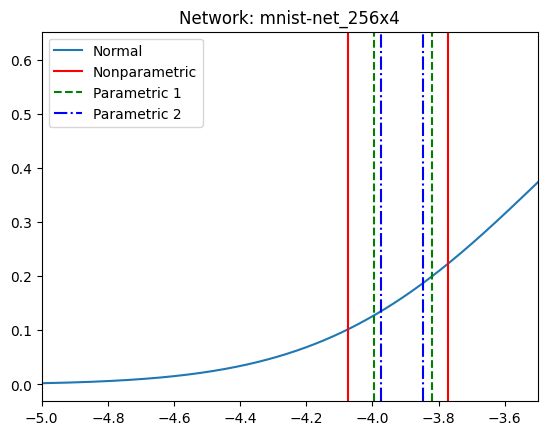

Network: mnist-net_256x4
Is Parametric 1 inside Nonparametric: True
Is Parametric 2 inside Nonparametric: True
------------------------


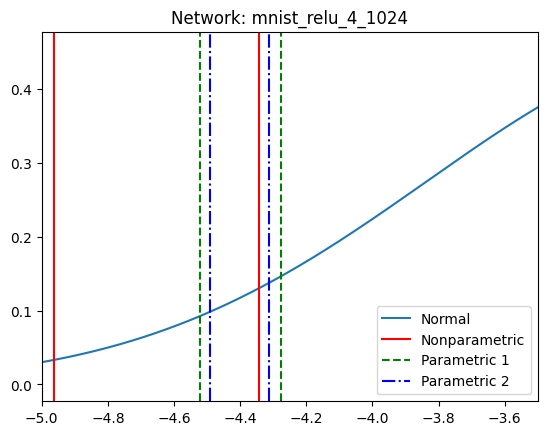

Network: mnist_relu_4_1024
Is Parametric 1 inside Nonparametric: False
Is Parametric 2 inside Nonparametric: False
------------------------


In [28]:
for network in networks:
    dat = log_crit_epsilons_network[network]
    mean = np.mean(dat)
    std = np.std(dat)

    nonparam = get_quantile(dat, 0.05)
    param1 = get_quantile_normal_orderdistr(dat, 0.05, mean, std)
    param2 = get_quantile_normal_tdistr(dat, 0.05, mean, std)

    x = np.linspace(np.min(dat), np.max(dat), 10000)
    plt.plot(x, norm.pdf(x, mean, std), label='Normal')

    plt.axvline(nonparam[1], color='r', label='Nonparametric')
    plt.axvline(nonparam[2], color='r')

    plt.axvline(param1[1], color='g', label='Parametric 1', linestyle='--')
    plt.axvline(param1[2], color='g', linestyle='--')

    plt.axvline(param2[0], color='b', label='Parametric 2', linestyle='-.')
    plt.axvline(param2[1], color='b', linestyle='-.')

    plt.legend()
    plt.xlim(-5,-3.5)
    plt.title(f'Network: {network}')
    plt.show()

    nonparam_lower = nonparam[1]
    nonparam_upper = nonparam[2]

    param1_lower = param1[1]
    param1_upper = param1[2]

    param2_lower = param2[0]
    param2_upper = param2[1]

    is_param1_inside_nonparam = nonparam_lower <= param1_lower <= nonparam_upper and nonparam_lower <= param1_upper <= nonparam_upper
    is_param2_inside_nonparam = nonparam_lower <= param2_lower <= nonparam_upper and nonparam_lower <= param2_upper <= nonparam_upper

    print(f'Network: {network}')
    print(f'Is Parametric 1 inside Nonparametric: {is_param1_inside_nonparam}')
    print(f'Is Parametric 2 inside Nonparametric: {is_param2_inside_nonparam}')
    print('------------------------')

# n choose N experiments
Step 2
- Go individually through all 3 methods and check how the uncertainties change with n
- To check this think of some rudimentary plot / metric
- Then think of some way to formalize it

Check:
- how n affects uncertainty size
- how n affects what model is winning

In [4]:
def sample_from_data(data, length_sample, n_samples, with_replacements = False):
    '''
    Sample from data with or without replacements. It is possible that a sample can repeat.
    
    Parameters:
    data: numpy array
    length_sample: int indicating the length of each sample
    n_samples: int indicating the number of samples to take
    with_replacements: bool indicating whether to sample with or without replacements
    
    Returns:
    samples: numpy array of shape (n_samples, length_sample)
    '''
    samples = np.array([np.random.choice(data, length_sample, replace=with_replacements) for i in range(n_samples)])
    return samples


In [7]:
n_samples = 1000
lens = np.arange(10, 900)
quantiles_nonparam = np.zeros((n_samples, len(lens), 2))
quantiles_param2 = np.zeros((n_samples, len(lens), 2))

quantiles_networks = {}

for network in networks:
    print(f'----------------- Network: {network} -----------------')
    data = log_crit_epsilons_network[network]
    for i, length in tqdm(enumerate(lens), total=len(lens)):
        if length > np.shape(data)[0]:
            continue
        
        samples = sample_from_data(data, length, n_samples)
        for j, sample in enumerate(samples):
            mean = np.mean(sample)
            std = np.std(sample)
            _, lower, upper = get_quantile(sample, 0.05)
            quantiles_nonparam[j, i, 0] = lower
            quantiles_nonparam[j, i, 1] = upper
            quantiles_param2[j, i, :] = get_quantile_normal_tdistr(sample, 0.05, mean, std)
    # Because we deal with pointers we need to copy the arrays
    quantiles_networks[network] = (np.copy(quantiles_nonparam), np.copy(quantiles_param2))



----------------- Network: mnist-net -----------------


100%|██████████| 890/890 [08:18<00:00,  1.79it/s]


----------------- Network: mnist-net_256x4 -----------------


100%|██████████| 890/890 [07:55<00:00,  1.87it/s]


----------------- Network: mnist_relu_4_1024 -----------------


100%|██████████| 890/890 [06:53<00:00,  2.15it/s]


In [5]:
# Save quantiles_networks into Datasets folder if it doesn't exist, otherwise load it
import pickle
import os

file_path = 'Datasets/quantiles_networks.pkl'

# Check if the file exists
if os.path.exists(file_path):
    print('Loading...')
    # Load the dictionary from the file
    with open(file_path, 'rb') as file:
        quantiles_networks = pickle.load(file)
    print('Loaded!')
else:
    print('Saving...')
    # Save the dictionary to the file
    with open(file_path, 'wb') as file:
        pickle.dump(quantiles_networks, file)
    print('Saved!')

lens = np.arange(10, 900)
n_samples = quantiles_networks[networks[0]][0].shape[0]

Loading...
Loaded!


In [10]:
quantiles_networks[networks[0]][1].shape

(1000, 890, 2)

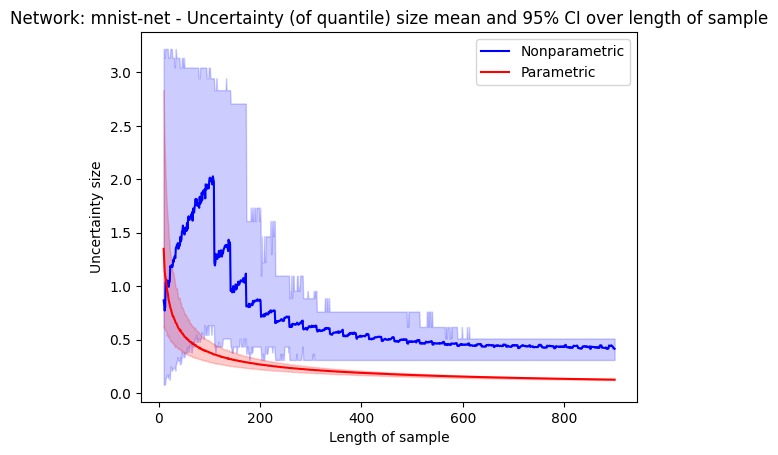

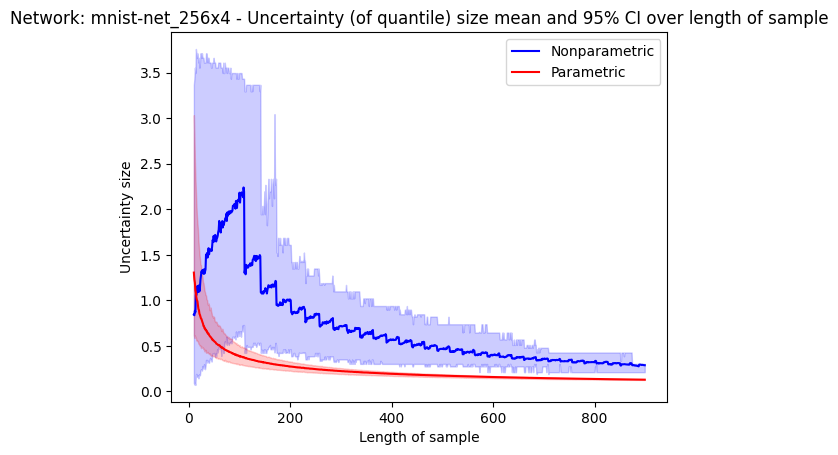

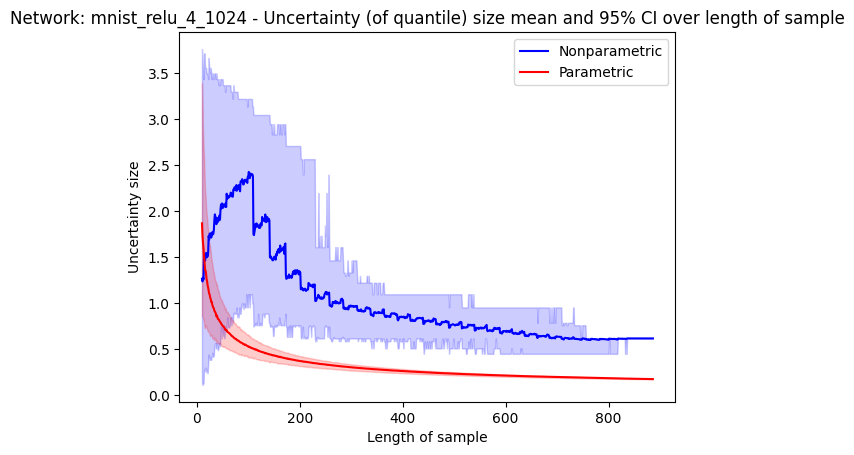

In [6]:
# plot to check size of uncertainty over length of sample, with uncertainties of course
for network in networks:
    nonparam = quantiles_networks[network][0]
    param = quantiles_networks[network][1]
    uncertainty_size_nonparam = nonparam[:, :, 1] - nonparam[:, :, 0]
    uncertainty_size_param = param[:, :, 1] - param[:, :, 0]
    
    mean_uncertainty_nonparam = np.mean(uncertainty_size_nonparam, axis=0)
    mean_uncertainty_param = np.mean(uncertainty_size_param, axis=0)
    
    #95% confidence interval for the uncertainty size
    conf_int_nonparam = np.percentile(uncertainty_size_nonparam, [2.5, 97.5], method = 'nearest',axis=0)
    conf_int_param = np.percentile(uncertainty_size_param, [2.5, 97.5], method = 'nearest',axis=0)
    
    if network == networks[2]:
        # remove values from 887 onwards
        lens = lens[:-13]
        mean_uncertainty_nonparam = mean_uncertainty_nonparam[:-13]
        mean_uncertainty_param = mean_uncertainty_param[:-13]
        conf_int_nonparam = conf_int_nonparam[:, :-13]
        conf_int_param = conf_int_param[:, :-13]
    
    
    
    fig, ax = plt.subplots()
    ax.plot(lens, mean_uncertainty_nonparam, label='Nonparametric', color='b')    
    ax.plot(lens, mean_uncertainty_param, label='Parametric', color='r')
    
    #confidence intervals
    ax.fill_between(lens, conf_int_nonparam[0], conf_int_nonparam[1], alpha=0.2, color='b')
    ax.fill_between(lens, conf_int_param[0], conf_int_param[1], alpha=0.2, color='r')
    
    #legend
    ax.legend()
    #labels
    ax.set_xlabel('Length of sample')
    ax.set_ylabel('Uncertainty size')
    ax.set_title(f'Network: {network} - Uncertainty (of quantile) size mean and 95% CI over length of sample')
    lens = np.arange(10, 900)


Text(0.5, 1.0, 'Parametric - Mean of quantile over length of sample')

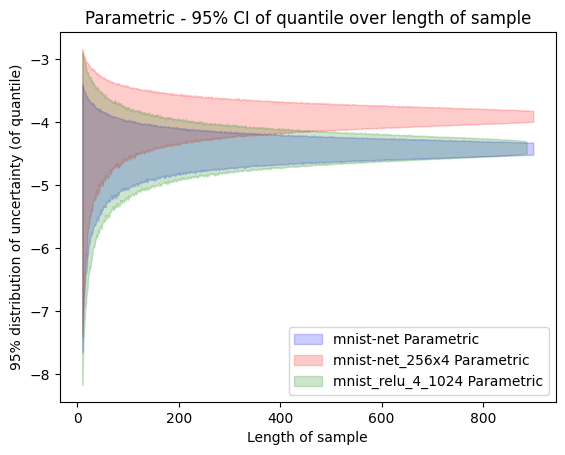

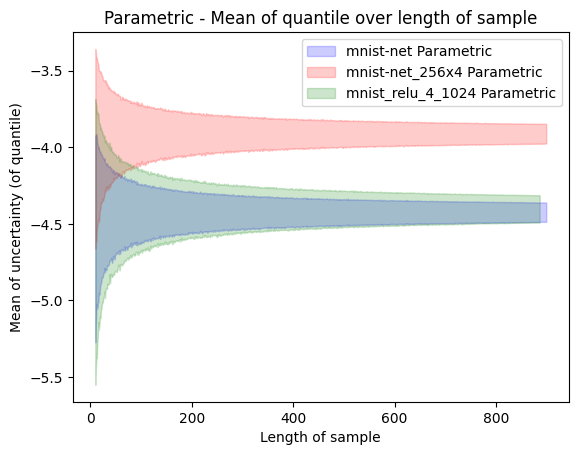

In [ ]:
# Plot distribution of right side and left side of quantile over length of sample
# First for parametric

plot_data = {}
for network in networks:
    nonparam = quantiles_networks[network][0]
    param = quantiles_networks[network][1]
    mean_left_param = np.mean(param[:, :, 0], axis=0)
    mean_right_param = np.mean(param[:, :, 1], axis=0)
    
    #95% confidence interval for the uncertainty size
    conf_int_left_param = np.percentile(param[:, :, 0], [2.5, 97.5], method = 'nearest',axis=0)
    conf_int_right_param = np.percentile(param[:, :, 1], [2.5, 97.5], method = 'nearest',axis=0)
    
    if network == networks[2]:
        # remove values from 887 onwards
        mean_left_param = mean_left_param[:-13]
        mean_right_param = mean_right_param[:-13]
        conf_int_left_param = conf_int_left_param[:, :-13]
        conf_int_right_param = conf_int_right_param[:, :-13]
    
    plot_data[network] = (mean_left_param, mean_right_param, conf_int_left_param, conf_int_right_param)

fig, ax = plt.subplots()
# ax.plot(lens, plot_data[networks[0]][0], label='Left side', color='b')
# ax.plot(lens, plot_data[networks[0]][1], label='Right side', color='cyan', linestyle='--')

# ax.plot(lens, plot_data[networks[1]][0], label='Left side', color='r')
# ax.plot(lens, plot_data[networks[1]][1], label='Right side', color='orange', linestyle='--')

#confidence intervals
ax.fill_between(lens, plot_data[networks[0]][2][0], plot_data[networks[0]][3][1], alpha=0.2, color='b', label=f'{networks[0]} Parametric')
# ax.fill_between(lens, plot_data[networks[0]][3][0], plot_data[networks[0]][3][1], alpha=0.2, color='cyan', linestyle='--')
    
ax.fill_between(lens, plot_data[networks[1]][2][0], plot_data[networks[1]][3][1], alpha=0.2, color='r', label=f'{networks[1]} Parametric')
# ax.fill_between(lens, plot_data[networks[1]][3][0], plot_data[networks[1]][3][1], alpha=0.2, color='orange', linestyle='--')

ax.fill_between(lens[:-13], plot_data[networks[2]][2][0], plot_data[networks[2]][3][1], alpha=0.2, color='g', label=f'{networks[2]} Parametric')

ax.legend()
ax.set_xlabel('Length of sample')
ax.set_ylabel('95% distribution of uncertainty (of quantile)')
ax.set_title('Parametric - 95% CI of quantile over length of sample')

fig, ax = plt.subplots()
ax.fill_between(lens, plot_data[networks[0]][0], plot_data[networks[0]][1], alpha=0.2, color='b', label=f'{networks[0]} Parametric')
ax.fill_between(lens, plot_data[networks[1]][0], plot_data[networks[1]][1], alpha=0.2, color='r', label=f'{networks[1]} Parametric')
ax.fill_between(lens[:-13], plot_data[networks[2]][0], plot_data[networks[2]][1], alpha=0.2, color='g', label=f'{networks[2]} Parametric')
ax.legend()
ax.set_xlabel('Length of sample')
ax.set_ylabel('Mean of uncertainty (of quantile)')
ax.set_title('Parametric - Mean of quantile over length of sample')

In [5]:
dat[networks[0]].shape

NameError: name 'dat' is not defined

In [4]:
# all combinations of networks
from itertools import combinations
from Helper.ImportDatasetsFairness import networks
print('All combinations of networks')
for comb in combinations(networks, 2):
    print(comb)

All combinations of networks
('mnist-net', 'mnist-net_256x4')
('mnist-net', 'mnist_relu_4_1024')
('mnist-net_256x4', 'mnist_relu_4_1024')


In [17]:
# check number of times one network wins over the other (percentage)
# Network 2 vs Network 1 check how often uncertainties overlap and how often network 2 is better
parametric_quantiles_net2 = quantiles_networks[networks[1]][1]
parametric_quantiles_net1 = quantiles_networks[networks[0]][1]

# check how often network 2 is better, do this for every length of sample
net2_better = np.full(len(lens), np.nan)
net1_better = np.full(len(lens), np.nan)
net_overlap = np.full(len(lens), np.nan)
for i, length in enumerate(lens):
    left_quantile_net2 = parametric_quantiles_net2[:, i, 0]
    right_quantile_net2 = parametric_quantiles_net2[:, i, 1]
    left_quantile_net1 = parametric_quantiles_net1[:, i, 0]
    right_quantile_net1 = parametric_quantiles_net1[:, i, 1]
    
    # check how often network 2 is better
    net2_better[i] = np.sum(left_quantile_net2 >= right_quantile_net1) / n_samples
    
    # check how often network 1 is better
    net1_better[i] = np.sum(left_quantile_net1 >= right_quantile_net2) / n_samples
    
    # check how often uncertainties overlap
    net_overlap[i] = np.sum((left_quantile_net2 <= right_quantile_net1) & (right_quantile_net2 >= left_quantile_net1)) / n_samples

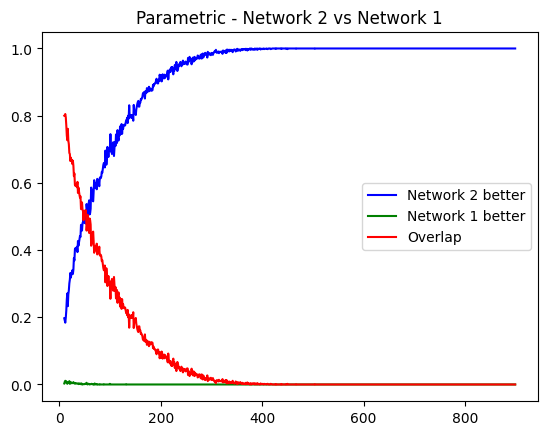

In [19]:
# plot the results
fig, ax = plt.subplots()
ax.plot(lens, net2_better, label='Network 2 better', color='b')
ax.plot(lens, net1_better, label='Network 1 better', color='g')
ax.plot(lens, net_overlap, label='Overlap', color='r')
ax.legend()
ax.title.set_text('Parametric - Network 2 vs Network 1')

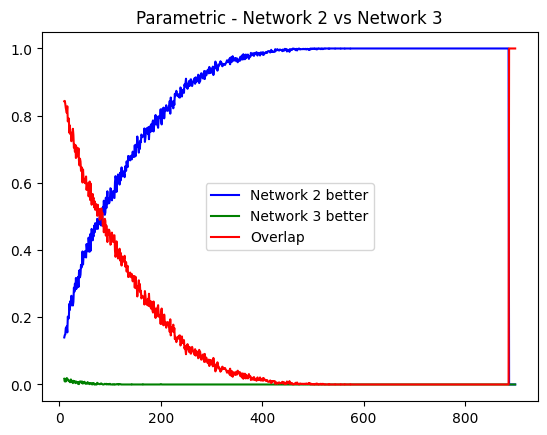

In [20]:
# Now for network 2 vs network 3
parametric_quantiles_net2 = quantiles_networks[networks[1]][1]
parametric_quantiles_net3 = quantiles_networks[networks[2]][1]

# check how often network 2 is better, do this for every length of sample
net2_better = np.full(len(lens), np.nan)
net3_better = np.full(len(lens), np.nan)
net_overlap = np.full(len(lens), np.nan)

for i, length in enumerate(lens):
    left_quantile_net2 = parametric_quantiles_net2[:, i, 0]
    right_quantile_net2 = parametric_quantiles_net2[:, i, 1]
    left_quantile_net3 = parametric_quantiles_net3[:, i, 0]
    right_quantile_net3 = parametric_quantiles_net3[:, i, 1]
    
    # check how often network 2 is better
    net2_better[i] = np.sum(left_quantile_net2 >= right_quantile_net3) / n_samples
    
    # check how often network 3 is better
    net3_better[i] = np.sum(left_quantile_net3 >= right_quantile_net2) / n_samples
    
    # check how often uncertainties overlap
    net_overlap[i] = np.sum((left_quantile_net2 <= right_quantile_net3) & (right_quantile_net2 >= left_quantile_net3)) / n_samples

# plot the results
fig, ax = plt.subplots()
ax.plot(lens, net2_better, label='Network 2 better', color='b')
ax.plot(lens, net3_better, label='Network 3 better', color='g')
ax.plot(lens, net_overlap, label='Overlap', color='r')
ax.legend()
ax.title.set_text('Parametric - Network 2 vs Network 3')

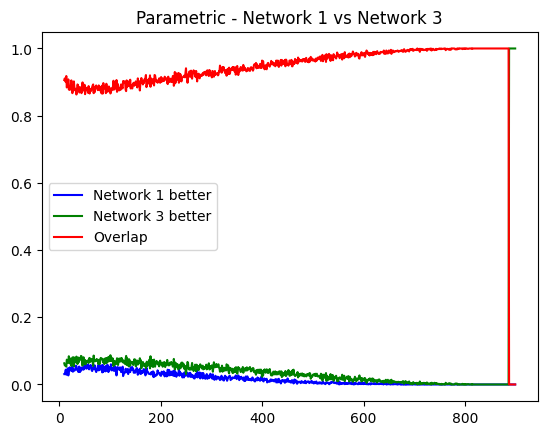

In [21]:
# Now for network 1 vs network 3
parametric_quantiles_net1 = quantiles_networks[networks[0]][1]
parametric_quantiles_net3 = quantiles_networks[networks[2]][1]

# check how often network 1 is better, do this for every length of sample
net1_better = np.full(len(lens), np.nan)
net3_better = np.full(len(lens), np.nan)
net_overlap = np.full(len(lens), np.nan)

for i, length in enumerate(lens):
    left_quantile_net1 = parametric_quantiles_net1[:, i, 0]
    right_quantile_net1 = parametric_quantiles_net1[:, i, 1]
    left_quantile_net3 = parametric_quantiles_net3[:, i, 0]
    right_quantile_net3 = parametric_quantiles_net3[:, i, 1]
    
    # check how often network 1 is better
    net1_better[i] = np.sum(left_quantile_net1 >= right_quantile_net3) / n_samples
    
    # check how often network 3 is better
    net3_better[i] = np.sum(left_quantile_net3 >= right_quantile_net1) / n_samples
    
    # check how often uncertainties overlap
    net_overlap[i] = np.sum((left_quantile_net1 <= right_quantile_net3) & (right_quantile_net1 >= left_quantile_net3)) / n_samples

# plot the results
fig, ax = plt.subplots()
ax.plot(lens, net1_better, label='Network 1 better', color='b')
ax.plot(lens, net3_better, label='Network 3 better', color='g')
ax.plot(lens, net_overlap, label='Overlap', color='r')
ax.legend()
ax.title.set_text('Parametric - Network 1 vs Network 3')